<h1><center>Lab 2: Classification</center></h1>
<h3><center>A Deeper Analysis of Covid-19 Data</center></h3>
<p><center>DS 7331</center></p>
<p><center>Created by Sadik Aman, Dawn Bowerman, Zachary Harris, Alexandre Jasserme</center></p>

<p><center>Sections of this code was adapted from: 
    <li>https://github.com/jakemdrew/DataMiningNotebooks</li>
    <li> https://scikit-learn.org/stable/auto_examples/linear_model/plot_theilsen.html</li>
    <li> https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html </li>

## Data Preparation Part 1 

> **Define and prepare your class variables. Use proper variable representations
(int, float, one-hot, etc.).
Use pre-processing methods (as needed) for dimensionality
reduction, scaling, etc. 
Remove variables that are not needed/useful for the analysis.**

In [1]:
from __future__ import print_function

#Libraries
import plotly
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import time
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pyplot import figure
from sklearn.model_selection import TimeSeriesSplit

# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
#Loading in the CSV file and displaying the resulting dataframe
df = pd.read_csv('Data/owid-covid-data_modified.csv') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34965 entries, 0 to 34964
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   continent                       34965 non-null  object 
 1   location                        34965 non-null  object 
 2   date                            34965 non-null  object 
 3   new_cases                       34965 non-null  float64
 4   new_cases_smoothed              34965 non-null  float64
 5   new_deaths                      34965 non-null  float64
 6   new_deaths_smoothed             34965 non-null  float64
 7   reproduction_rate               34965 non-null  float64
 8   new_vaccinations_smoothed       34965 non-null  float64
 9   new_people_vaccinated_smoothed  34965 non-null  float64
 10  stringency_index                34965 non-null  float64
 11  population                      34965 non-null  int64  
 12  population_density              

In [3]:
# Ideas from https://scikit-learn.org/stable/modules/cross_validation.html#timeseries-cv

# Sorting data frame by date column
df['date'] = pd.to_datetime(df['date']) # Converting data columnn to datetime

df = df.sort_values(by='date', ascending=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34965 entries, 0 to 34964
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   continent                       34965 non-null  object        
 1   location                        34965 non-null  object        
 2   date                            34965 non-null  datetime64[ns]
 3   new_cases                       34965 non-null  float64       
 4   new_cases_smoothed              34965 non-null  float64       
 5   new_deaths                      34965 non-null  float64       
 6   new_deaths_smoothed             34965 non-null  float64       
 7   reproduction_rate               34965 non-null  float64       
 8   new_vaccinations_smoothed       34965 non-null  float64       
 9   new_people_vaccinated_smoothed  34965 non-null  float64       
 10  stringency_index                34965 non-null  float64       
 11  po

In [4]:
covid_df = df.drop(["new_deaths_smoothed",
                    "new_cases",
                    "new_cases_smoothed",
                    "continent",
                    "location",
                    "stringency_range",
                    "new_cases_range",
                    "date",
                    "new_people_vaccinated_smoothed",
                    "population_density",
                    "aged_70_older",
                    "cardiovasc_death_rate",
                    "new_deaths_range"], axis=1)


covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34965 entries, 0 to 34964
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   new_deaths                  34965 non-null  float64
 1   reproduction_rate           34965 non-null  float64
 2   new_vaccinations_smoothed   34965 non-null  float64
 3   stringency_index            34965 non-null  float64
 4   population                  34965 non-null  int64  
 5   median_age                  34965 non-null  float64
 6   aged_65_older               34965 non-null  float64
 7   gdp_per_capita              34965 non-null  float64
 8   diabetes_prevalence         34965 non-null  float64
 9   handwashing_facilities      34965 non-null  float64
 10  hospital_beds_per_thousand  34965 non-null  float64
 11  life_expectancy             34965 non-null  float64
 12  human_development_index     34965 non-null  float64
dtypes: float64(12), int64(1)
memory

In [5]:
print ('Size of the dataset:', covid_df.shape)
print ('Number of unique classes:', len(covid_df.new_deaths))

Size of the dataset: (34965, 13)
Number of unique classes: 34965


 ## Data Preparation Part 2

> **Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).**

 ## Modeling and Evaluation 1

> **Choose and explain your evaluation metrics that you will use (i.e., accuracy,precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.**

> We have selected the Root Mean Squared Error (RMSE) for our evaluation metric.  The RMSE measures the average error produced by the model while predicting the result for a study. The RMSE is the square root of the mean squared error (MSE); the average squared difference between the observed actual results and the results predicted by the model. The MSE = mean((observed - predicted)^2) and the RMSE = sqrt(MSE). A model with a lower RMSE is a better model.  We believe that this metric is appropriate because RMSE is a mathematical equation that equates the error between the predicted and the actual results to determine the correctness of a model.  Since most of our data is numerical it is a likely choice as metrics for binary data will not work here.

 ## Modeling and Evaluation 2

> **Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.**

In [6]:

iter_num=0
# the indices are the rows used for training and testing in each iteration

cv_object = TimeSeriesSplit( n_splits=10)

covid_target = covid_df.new_deaths


#separate the other attributes from the predicting attribute
covid_df = covid_df.drop("new_deaths",axis=1)

X = np.array(covid_df)
y = np.array(covid_target)


# TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
for train_index, test_index in cv_object.split(X):
   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


 ## Modeling and Evaluation 3

> **Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!**

> We have selected RANSAC Regression, Theil-sen Regression, and Support Vector Machine models to analyze our data

## Support Vector Machines

#### Creating the Model Using Support Vector Machines

In [7]:
cat_df = df.drop(["new_deaths_smoothed",
                    "new_cases",
                    "new_cases_smoothed",
                    "continent",
                    "location",
                    "stringency_range",
                    "new_cases_range",
                    "date",
                    "new_people_vaccinated_smoothed",
                    "population_density",
                    "aged_70_older",
                    "cardiovasc_death_rate",
                    "new_deaths"], axis=1)


cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34965 entries, 0 to 34964
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reproduction_rate           34965 non-null  float64
 1   new_vaccinations_smoothed   34965 non-null  float64
 2   stringency_index            34965 non-null  float64
 3   population                  34965 non-null  int64  
 4   median_age                  34965 non-null  float64
 5   aged_65_older               34965 non-null  float64
 6   gdp_per_capita              34965 non-null  float64
 7   diabetes_prevalence         34965 non-null  float64
 8   handwashing_facilities      34965 non-null  float64
 9   hospital_beds_per_thousand  34965 non-null  float64
 10  life_expectancy             34965 non-null  float64
 11  human_development_index     34965 non-null  float64
 12  new_deaths_range            34965 non-null  object 
dtypes: float64(11), int64(1), objec

In [8]:
iter_num=0
# the indices are the rows used for training and testing in each iteration

cv_object = TimeSeriesSplit( n_splits=10)

cat_target = cat_df.new_deaths_range


#separate the other attributes from the predicting attribute
cat_df = cat_df.drop("new_deaths_range",axis=1)

X = np.array(cat_df)
y = np.array(cat_target)


# TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
for train_index, test_index in cv_object.split(X):
   
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    
    

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)



In [9]:
y_train

array(['high', 'low', 'high', ..., 'medium', 'low', 'medium'],
      dtype=object)

accuracy: 0.6718061674008811
[[ 761   75   92]
 [ 192  250  407]
 [ 108  169 1124]]
(20215, 12)
(20215,)
[5368 6909 7938]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20215 entries, 0 to 34763
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reproduction_rate           20215 non-null  float64
 1   new_vaccinations_smoothed   20215 non-null  float64
 2   stringency_index            20215 non-null  float64
 3   population                  20215 non-null  int64  
 4   median_age                  20215 non-null  float64
 5   aged_65_older               20215 non-null  float64
 6   gdp_per_capita              20215 non-null  float64
 7   diabetes_prevalence         20215 non-null  float64
 8   handwashing_facilities      20215 non-null  float64
 9   hospital_beds_per_thousand  20215 non-null  float64
 10  life_expectancy             20215 non-null  float64
 11  human_development_index

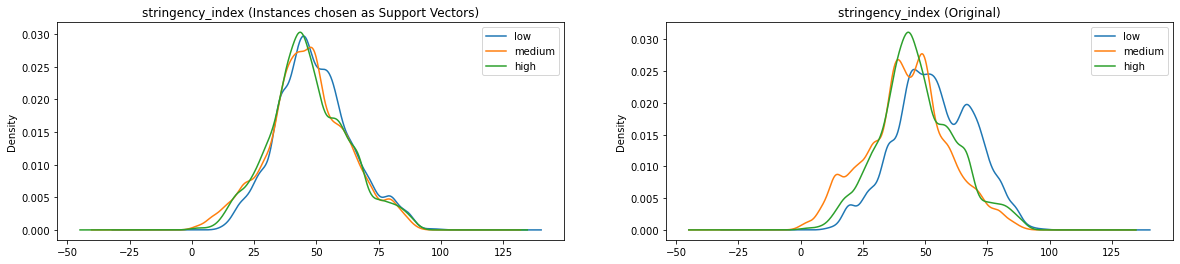

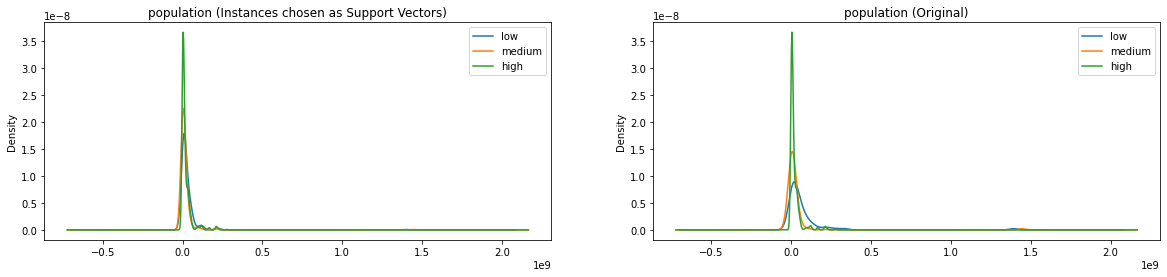

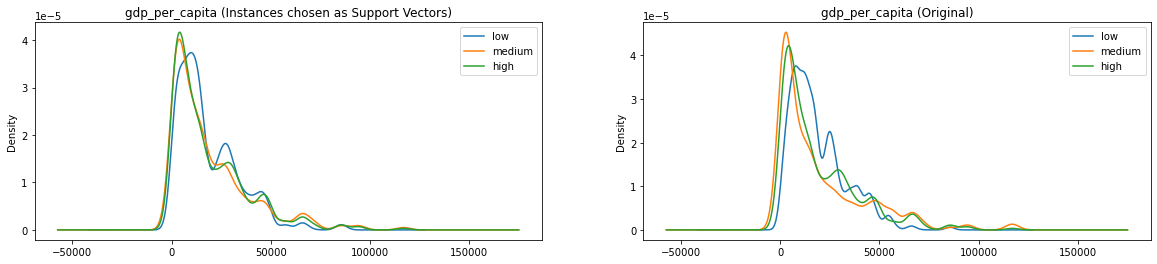

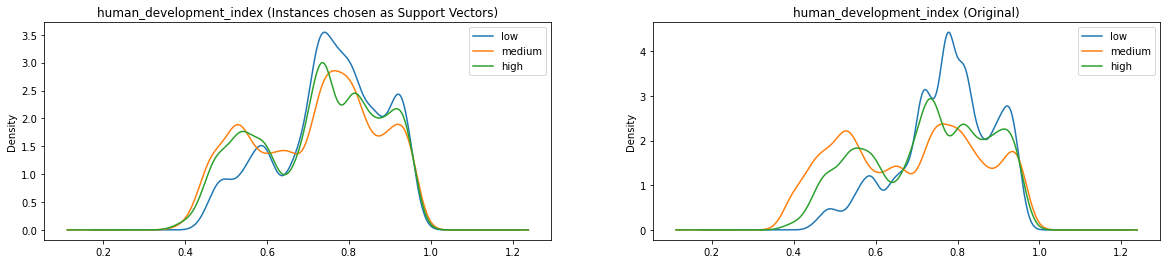

In [10]:
iter_num=0
# the indices are the rows used for training and testing in each iteration

cv_object = TimeSeriesSplit( n_splits=10)



# cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)



X_train_scaled = scl_obj.transform(X_train) # apply to training
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 
# SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model
svm_clf = SVC(C=0.5, kernel='rbf', decision_function_shape='ovo', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set predictions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat, labels = ["high","medium","low"])
print('accuracy:', acc )
print(conf)
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

# make a dataframe of the training data
df_tested_on = cat_df.iloc[train_indices].copy() # saved from above, the indices chosen for training
# get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['new_deaths_range'] = y[svm_clf.support_] # add back in the 'new_deaths_range' Column to the pandas dataframe
cat_df['new_deaths_range'] = y # also add it back in for the original data
df_support.info()

# statistics of the attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['new_deaths_range'])
df_grouped = cat_df.groupby(['new_deaths_range'])

# plot KDE of Different variables
vars_to_plot = ['stringency_index','population','gdp_per_capita','human_development_index']

for v in vars_to_plot:
    plt.figure(figsize=(20,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['low','medium','high'])
    plt.title(v+' (Original)')

 ## Theil-sen Regression

In [11]:
## KFold cross-validation   **** I think this should be moved.

#separate the predicting attribute into Y for model training
covid_target = covid_df.new_deaths

#separate the other attributes from the predicting attribute
covid_df = covid_df.drop("new_deaths",axis=1)

## Define variables for the for loop
kf = KFold(n_splits=10)
RMSE_sum=0
RMSE_length=10
X = np.array(covid_df)
y = np.array(covid_target)
print(X)
print(y)
print(covid_target)

AttributeError: 'DataFrame' object has no attribute 'new_deaths'

In [ ]:
  for loop_number, (train, test) in enumerate(kf.split(X)):
    
    
    ## Get Training Matrix and Vector

    training_X_array = X[train]
    training_y_array = y[train]

    ## Get Testing Matrix Values

    X_test_array = X[test]
    y_actual_values = y[test]

    ## Fit the Linear Regression Model

    lr_model = LinearRegression().fit(training_X_array, training_y_array)

    ## Compute the predictions for the test data

    prediction = lr_model.predict(X_test_array)      
    deaths_probabilites = np.array(prediction)   

    ## Calculate the RMSE

    RMSE_cross_fold = mean_squared_error(deaths_probabilites, y_actual_values)

    ## Add each RMSE_cross_fold value to the sum

    RMSE_sum=RMSE_cross_fold+RMSE_sum

## Calculate the average and print    

RMSE_cross_fold_avg=RMSE_sum/RMSE_length

print('The Mean RMSE across all folds is',RMSE_cross_fold_avg)

 ## Modeling and Evaluation 4

> Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

 ## Modeling and Evaluation 5

> Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

 ## Modeling and Evaluation 6

> Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

 ## Deployment

> How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? 


> How would you measure the model's value if it was used by these parties? 

> How would your deploy your model for interested parties? 

> What other data should be collected? 

> How often would the model need to be updated, etc.? 

 ## Exceptional Work

> You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?